# Maass Portrait Experiments #

I document portrait experiments here. The goal is to make $200\times200$ pixel portraits for Maass forms.

I use a custom, quick, low precision $K$-Bessel function calculator due to Strömberg. This needs to be compiled separately. An overly simple `Makefile` is included that performs the necessary command on machines where `sage` is in the PATH.

In [1]:
from lpkbessel import besselk_dp
besselk_dp(10.0, 5.0, pref=1)

-0.7183327166568128

The function `besselk_dp(R, x, pref=1)` function computes
$$ \exp(\pi R / 2) \cdot K_{iR}(x) $$
to double precision. The exponential factor helps counteract exponential decay in the Bessel functions.

We can compare this to sage's inbuild `bessel_K`

In [2]:
n(bessel_K(10.0 * 1j, 5.0) * exp(pi * 10.0 / 2.))

-0.718332716656817

We see small numerical differences. But (at least historically) the lpk version is faster. We experiment with these differences in this notebook too.

In [3]:
%time
print(n(bessel_K(10.0 * 1j, 5.0) * exp(pi * 10.0 / 2.)))

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.48 µs
-0.718332716656817


## Model Data ##

I use a random rigorous Maass form in the current branch I'm adding to the LMFDB. It happens to be a level $35$ form with spectral parameter $12.982731$. It is an even form. Its first $50$ coefficients are as follows.

In [4]:
R = 12.9827317296260657613548775278
symmetry = 0
coeffs = [1,
 1.64351344560035367390427086548,
 0.420551381883206072903263382234,
 1.70113644586919928411975832696,
 0.447213595499957939281834733746,
 0.691181850690915491341100532616,
 -0.377964473009227227214516536234,
 1.15232717598656033402301570008,
 -0.823136535196071452739639971446,
 0.73500155725945869522252727443,
 -0.672501128518829987400368643509,
 0.715415283082266032844945528497,
 0.198111881653547898515185080591,
 -0.621189693349916916963509016354,
 0.188076295584464460237356138062,
 0.192728761595425261922937286623,
 -1.21609403303096993967926724371,
 -1.35283596315967176578104069743,
 1.7977998708891506290069193287,
 0.760771346393184183536612806889,
 -0.158953481426788254051296779919,
 -1.10526464690215634985041491702,
 0.0419781909901593553258692784929,
 0.484612786242759350114801265381,
 0.2,
 0.325599541230805117744695525486,
 -0.766722589238525329465471572118,
 -0.642969140279741706863231937071,
 -1.53042074452220173081941152178,
 0.309105920591799404464279828381,
 -1.80163626427756747623838762053,
 -0.835574864950594186428459073337,
 -0.282821278916645685895127656571,
 -1.99866689440080083740153828774,
 -0.169030850945703315501923665473,
 -1.40026755994860591368875549051,
 0.31681460014830585473237749836,
 2.95470826030490922492021578091,
 0.0833162255969015372924995652723,
 0.515336379565262438947530483106,
 0.386262111251425420013442349259,
 -0.261242183949934251555150246645,
 -1.12951502643569838344102238272,
 -1.1440161796116176564123174191,
 -0.368117849492412790140784301278,
 0.0689917213142714765247748308388,
 0.295791719180783126638277517602,
 0.0810523470175750251007930873456,
 0.142857142857142857142857142857,
 0.328702689120070734780854173096]

As this is an even form, it can be written in the form
$$ f(z) = \sum_{n \geq 1} a(n)  \sqrt{y} K_{iR} (2 \pi n y) \cos(2 \pi n x), $$
where $z = x + iy$ as expected. In practice, this is annoyingly small as $R$ grows, so we will instead look at
$$ f(z) \exp(\pi R / 2) $$
and compute $K_{iR}$ using the other preference above.

In [5]:
# Map the disk D to the hyperbolic upper halfplane

DtoH = lambda x: (-CDF.0*x + 1)/(x - CDF.0)
twopi = RR(2 * pi)

In [6]:
CC(pi)

3.14159265358979

In [7]:
class maassform:
    def __init__(self, spectral_parameter, symmetry, coeffs):
        self.r = spectral_parameter
        self.symmetry = symmetry
        self.coeffs = coeffs
        if self.symmetry == 0:
            self.trig = cos
        else:
            self.trig = sin
        
    def __call__(self, z, num_coeffs=50):
        ret = RR(0)
        x = real(z)
        y = imag(z)
        sqrty = sqrt(RR(y))
        for n, coeff in enumerate(self.coeffs[:num_coeffs], 1):
            ret += coeff * sqrty * besselk_dp(self.r, twopi * n * y, pref=1) * self.trig(twopi * n * x)
        return ret

In [8]:
f = maassform(R, symmetry, coeffs)
f(1.5 + 2j)

-0.988642898006482

In [9]:
class maassform_mpmath:
    def __init__(self, spectral_parameter, symmetry, coeffs):
        self.r = spectral_parameter
        self.symmetry = symmetry
        self.coeffs = coeffs
        self.factor = exp(RR(spectral_parameter * pi / 2.))
        if self.symmetry == 0:
            self.trig = cos
        else:
            self.trig = sin
        
    def __call__(self, z, num_coeffs=50):
        ret = RR(0)
        x = real(z)
        y = imag(z)
        sqrty = sqrt(RR(y))
        for n, coeff in enumerate(self.coeffs[:num_coeffs], 1):
            ret += RR(coeff * sqrty * real(bessel_K(self.r * 1j, twopi * n * y)) * self.trig(twopi * n * x))
        return ret*self.factor

In [10]:
fmp = maassform_mpmath(R, symmetry, coeffs)
fmp(1.5 + 2j)

-0.988642898006479

In [11]:
import time

42.856789350509644 time elapsed


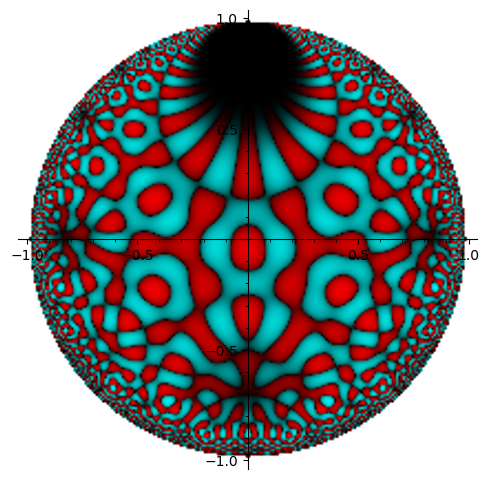

In [12]:
start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else f(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=200, aspect_ratio=1, figsize=[5, 5])
end = time.time()
print(f"{end - start} time elapsed")
P.show()

In [13]:
# This takes forever

#start = time.time()
# P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fmp(DtoH(z)),
#             (-1, 1), (-1, 1), plot_points=200, aspect_ratio=1, figsize=[5, 5])
#end = time.time()
print(f"{end - start} time elapsed")
#P.show()

42.856789350509644 time elapsed


48.57095646858215 time elapsed


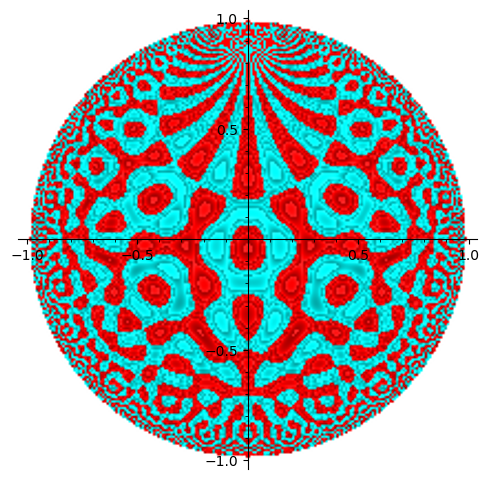

In [14]:
start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else f(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=200, aspect_ratio=1, figsize=[5, 5],
             contoured=True, dark_rate=0)
end = time.time()
print(f"{end - start} time elapsed")
P.show()

In [15]:
#start = time.time()
#P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fmp(DtoH(z)),
#             (-1, 1), (-1, 1), plot_points=200, aspect_ratio=1, figsize=[5, 5],
#             contoured=True, dark_rate=0)
#end = time.time()
#print(f"{end - start} time elapsed")
#P.show()

47.45987868309021 time elapsed


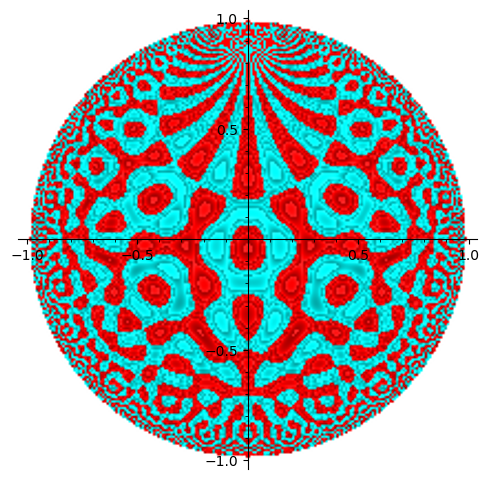

In [16]:
start = time.time()
complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else f(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=200, aspect_ratio=1, figsize=[5, 5],
             dark_rate=0)
end = time.time()
print(f"{end - start} time elapsed")
P.show()

In [17]:
# Can I cython my way to a better evaluator?
from maass_evaluator import maassform
fcc = maassform(R, symmetry, coeffs)

3.8412885665893555 time elapsed


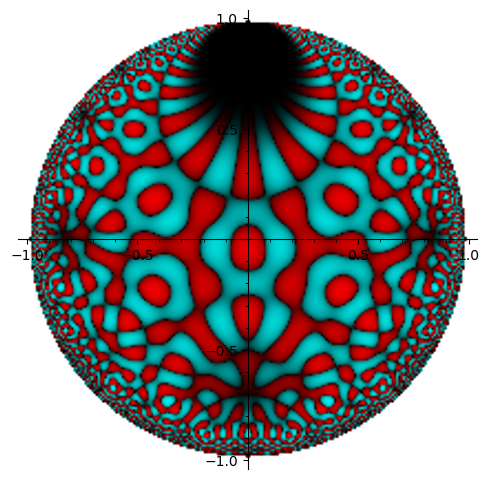

In [18]:
start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=200, aspect_ratio=1, figsize=[5, 5])
end = time.time()
print(f"{end - start} time elapsed")
P.show()

3.3860106468200684 time elapsed


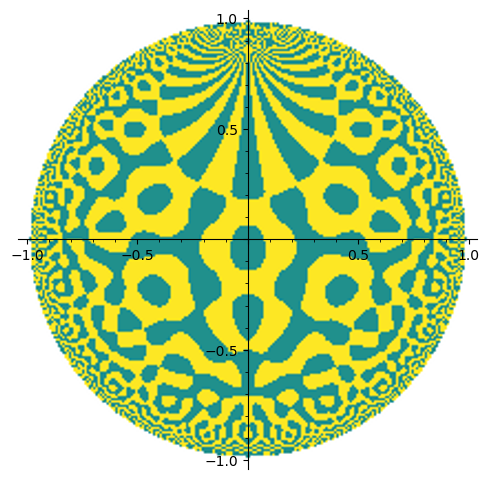

In [19]:
start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=200, aspect_ratio=1, figsize=[5, 5],
             dark_rate=0.0, contoured=True, cmap='viridis')
end = time.time()
print(f"{end - start} time elapsed")
P.show()

In [20]:
import numpy as np
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [21]:
Overall_HEX = {
    "blue": "#4677CB",
    "lilac": "#BF8FEC",
    "green": "#60B489",
    "orange": "#E69367",
    "red": "#D76055",
}
torder = ["blue", "lilac", "orange", "green", "red"]
tcmap = LinearSegmentedColormap.from_list(
    "tcmap",
    [mpl.colors.to_rgb(Overall_HEX[cname]) for cname
        in reversed(torder)]
)
tcmap_cyclic = LinearSegmentedColormap.from_list(
    "tcmap_cyclic",
    [mpl.colors.to_rgb(Overall_HEX[cname]) for cname in torder[:-1]] +
    [mpl.colors.to_rgb(Overall_HEX[cname]) for cname in reversed(torder)]
)

Ok, using my cython Maass computer with a cython K-Bessel computer is by far the way to go.
Now I'm testing sizes and number of plot points to to what extent they matter.

Remember, the goal is to have something in the range of $200 \times 200$ pixels, which really aren't very much.

38.49038648605347 time elapsed


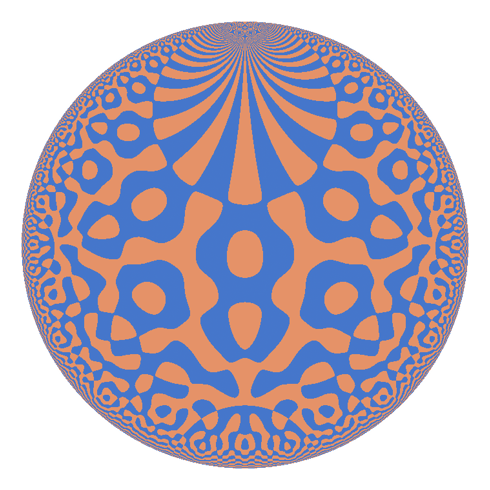

In [22]:
start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=700, aspect_ratio=1, figsize=[5, 5],
             dark_rate=0.0, contoured=True, cmap=tcmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save_image("size5.png", transparent=True)
P.show()

39.9228241443634 time elapsed


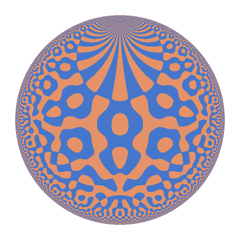

In [23]:
start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=700, aspect_ratio=1, figsize=[2.5, 2.5],
             dark_rate=0.0, contoured=True, cmap=tcmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save_image("size2.5.png", transparent=True)
P.show()

3.0404179096221924 time elapsed


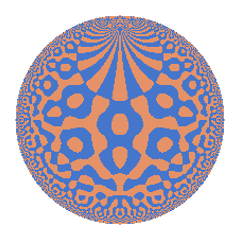

In [24]:
start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=200, aspect_ratio=1, figsize=[2.5, 2.5],
             dark_rate=0.0, contoured=True, cmap=tcmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save_image("points200size2.5.png", transparent=True)
P.show()

1.8077316284179688 time elapsed


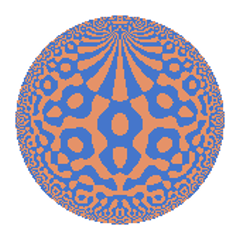

In [25]:
start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=150, aspect_ratio=1, figsize=[2.5, 2.5],
             dark_rate=0.0, contoured=True, cmap=tcmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save_image("points150size2.5.png", transparent=True)
P.show()

4.793586492538452 time elapsed


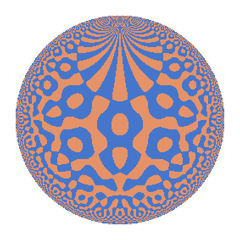

In [26]:
start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=250, aspect_ratio=1, figsize=[2.5, 2.5],
             dark_rate=0.0, contoured=True, cmap=tcmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save_image("points250size2.5.png", transparent=True)
P.show()

I notice that 200 points really is better than 150. And 250 is slightly better still. Oh, annoyingly 700 points is still relevant, even at $240\times240$ pixels (which is what this sizing seems to be right now). Let's make them slightly smaller and try again.

20.03877854347229 time elapsed


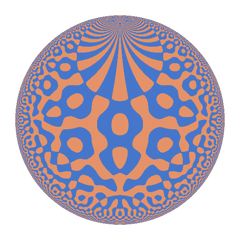

In [27]:
start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=500, aspect_ratio=1, figsize=[2.5, 2.5],
             dark_rate=0.0, contoured=True, cmap=tcmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save_image("points500size2.2.png", transparent=True)
P.show()

Oh, `save_image` doesn't use the precomputed figure size. What a pain.

In [28]:
P.save("points500size2.2.png", figsize=[2.2, 2.2], axes=False, transparent=True)

38.62412929534912 time elapsed


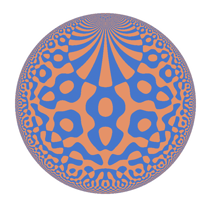

In [29]:
ppoints = 700
psize = 2.2

start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=ppoints, aspect_ratio=1, figsize=[psize, psize],
             dark_rate=0.0, contoured=True, cmap=tcmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save(f"points{ppoints}size{psize}.png", figsize=[psize, psize], axes=False, transparent=True)
P.show()

21.035083770751953 time elapsed


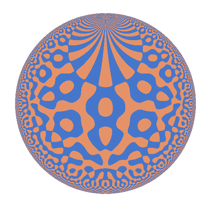

In [30]:
ppoints = 500
psize = 2.2

start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=ppoints, aspect_ratio=1, figsize=[psize, psize],
             dark_rate=0.0, contoured=True, cmap=tcmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save(f"points{ppoints}size{psize}.png", figsize=[psize, psize], axes=False, transparent=True)
P.show()

6.92091965675354 time elapsed


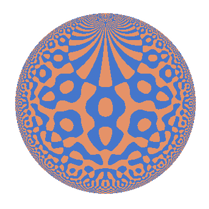

In [31]:
ppoints = 300
psize = 2.2

start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=ppoints, aspect_ratio=1, figsize=[psize, psize],
             dark_rate=0.0, contoured=True, cmap=tcmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save(f"points{ppoints}size{psize}.png", figsize=[psize, psize], axes=False, transparent=True)
P.show()

4.714168310165405 time elapsed


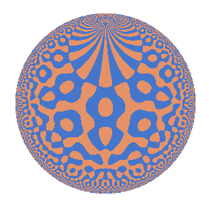

In [32]:
ppoints = 250
psize = 2.2

start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=ppoints, aspect_ratio=1, figsize=[psize, psize],
             dark_rate=0.0, contoured=True, cmap=tcmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save(f"points{ppoints}size{psize}.png", figsize=[psize, psize], axes=False, transparent=True)
P.show()

3.515976667404175 time elapsed


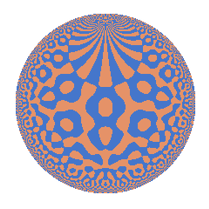

In [33]:
ppoints = 210
psize = 2.2

start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=ppoints, aspect_ratio=1, figsize=[psize, psize],
             dark_rate=0.0, contoured=True, cmap=tcmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save(f"points{ppoints}size{psize}.png", figsize=[psize, psize], axes=False, transparent=True)
P.show()

1.7262792587280273 time elapsed


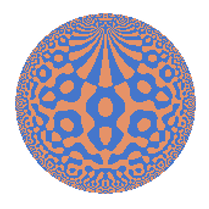

In [34]:
ppoints = 150
psize = 2.2

start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=ppoints, aspect_ratio=1, figsize=[psize, psize],
             dark_rate=0.0, contoured=True, cmap=tcmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save(f"points{ppoints}size{psize}.png", figsize=[psize, psize], axes=False, transparent=True)
P.show()

I'm confused why I can't make the background transparent... Oh, actually I do see. The point is that I'm actually plotting something (namely, the color white) there. So it's a bit different. I need to reprocess the files to make them have transparent backgrounds. I guess I'll do what with imagemagick.

$300$ points seem like enough. Now let's try a variety of colormaps.

8.195232152938843 time elapsed


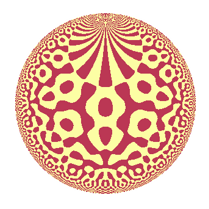

In [35]:
ppoints = 300
psize = 2.2
thiscmap = "inferno"

start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=ppoints, aspect_ratio=1, figsize=[psize, psize],
             dark_rate=0.0, contoured=True, cmap=thiscmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save(f"cmap_{thiscmap}.png", figsize=[psize, psize], axes=False, transparent=True)
P.show()

9.085192441940308 time elapsed


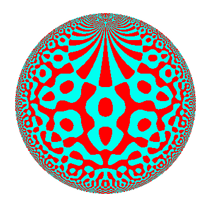

In [36]:
ppoints = 300
psize = 2.2
thiscmap = "matplotlib"

start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=ppoints, aspect_ratio=1, figsize=[psize, psize],
             dark_rate=0.0, contoured=True, cmap=thiscmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save(f"cmap_{thiscmap}.png", figsize=[psize, psize], axes=False, transparent=True)
P.show()

7.249997138977051 time elapsed


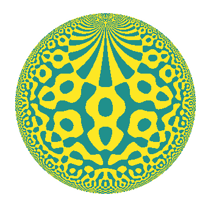

In [37]:
ppoints = 300
psize = 2.2
thiscmap = "viridis"

start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=ppoints, aspect_ratio=1, figsize=[psize, psize],
             dark_rate=0.0, contoured=True, cmap=thiscmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save(f"cmap_{thiscmap}.png", figsize=[psize, psize], axes=False, transparent=True)
P.show()

6.76614236831665 time elapsed


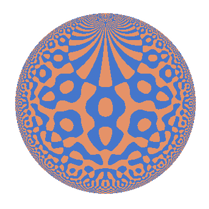

In [38]:
ppoints = 300
psize = 2.2
thiscmap = tcmap

start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=ppoints, aspect_ratio=1, figsize=[psize, psize],
             dark_rate=0.0, contoured=True, cmap=thiscmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save(f"cmap_quanta.png", figsize=[psize, psize], axes=False, transparent=True)
P.show()

7.71087384223938 time elapsed


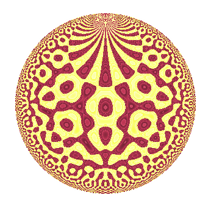

In [39]:
ppoints = 300
psize = 2.2
thiscmap = "inferno"

start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=ppoints, aspect_ratio=1, figsize=[psize, psize],
             dark_rate=0.5, contoured=True, cmap=thiscmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save(f"cmap_{thiscmap}_contour.png", figsize=[psize, psize], axes=False, transparent=True)
P.show()

7.0733113288879395 time elapsed


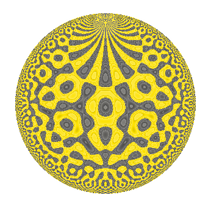

In [40]:
ppoints = 300
psize = 2.2
thiscmap = "cividis"

start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=ppoints, aspect_ratio=1, figsize=[psize, psize],
             dark_rate=0.5, contoured=True, cmap=thiscmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save(f"cmap_{thiscmap}_contour.png", figsize=[psize, psize], axes=False, transparent=True)
P.show()

6.75988507270813 time elapsed


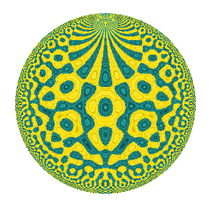

In [41]:
ppoints = 300
psize = 2.2
thiscmap = "viridis"

start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=ppoints, aspect_ratio=1, figsize=[psize, psize],
             dark_rate=0.5, contoured=True, cmap=thiscmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save(f"cmap_{thiscmap}_contour.png", figsize=[psize, psize], axes=False, transparent=True)
P.show()

6.75013279914856 time elapsed


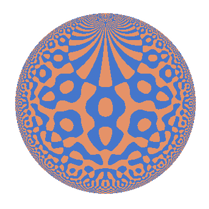

In [42]:
ppoints = 300
psize = 2.2
thiscmap = tcmap

start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=ppoints, aspect_ratio=1, figsize=[psize, psize],
             dark_rate=0.0, contoured=True, cmap=thiscmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save(f"cmap_quanta.png", figsize=[psize, psize], axes=False, transparent=True)
P.show()

6.676326751708984 time elapsed


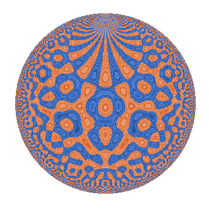

In [43]:
ppoints = 300
psize = 2.2
thiscmap = tcmap

start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=ppoints, aspect_ratio=1, figsize=[psize, psize],
             dark_rate=0.5, contoured=True, cmap=thiscmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save(f"cmap_quanta_contour.png", figsize=[psize, psize], axes=False, transparent=True)
P.show()

6.896679401397705 time elapsed


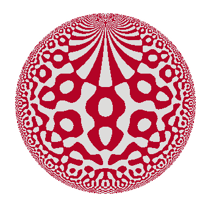

In [44]:
ppoints = 300
psize = 2.2
thiscmap = "coolwarm"

start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=ppoints, aspect_ratio=1, figsize=[psize, psize],
             dark_rate=0.0, contoured=True, cmap=thiscmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save(f"cmap_{thiscmap}.png", figsize=[psize, psize], axes=False, transparent=True)
P.show()

6.763108015060425 time elapsed


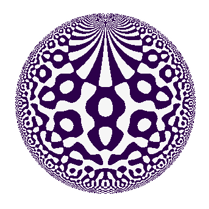

In [45]:
ppoints = 300
psize = 2.2
thiscmap = "PuOr"

start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=ppoints, aspect_ratio=1, figsize=[psize, psize],
             dark_rate=0.0, contoured=True, cmap=thiscmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save(f"cmap_{thiscmap}.png", figsize=[psize, psize], axes=False, transparent=True)
P.show()

6.805428743362427 time elapsed


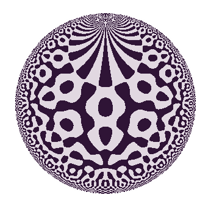

In [46]:
ppoints = 300
psize = 2.2
thiscmap = "twilight"

start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=ppoints, aspect_ratio=1, figsize=[psize, psize],
             dark_rate=0.0, contoured=True, cmap=thiscmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save(f"cmap_{thiscmap}.png", figsize=[psize, psize], axes=False, transparent=True)
P.show()

7.629966497421265 time elapsed


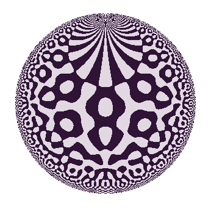

In [47]:
ppoints = 300
psize = 2.2
thiscmap = "twilight_shifted"

start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=ppoints, aspect_ratio=1, figsize=[psize, psize],
             dark_rate=0.0, contoured=True, cmap=thiscmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save(f"cmap_{thiscmap}.png", figsize=[psize, psize], axes=False, transparent=True)
P.show()

7.2092626094818115 time elapsed


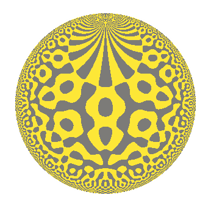

In [48]:
ppoints = 300
psize = 2.2
thiscmap = "cividis"

start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=ppoints, aspect_ratio=1, figsize=[psize, psize],
             dark_rate=0.0, contoured=True, cmap=thiscmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save(f"cmap_{thiscmap}.png", figsize=[psize, psize], axes=False, transparent=True)
P.show()

7.139025926589966 time elapsed


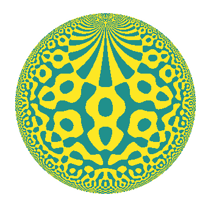

In [49]:
ppoints = 300
psize = 2.2
thiscmap = "viridis"

start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=ppoints, aspect_ratio=1, figsize=[psize, psize],
             dark_rate=0.0, contoured=True, cmap=thiscmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save(f"cmap_{thiscmap}.png", figsize=[psize, psize], axes=False, transparent=True)
P.show()

7.139893531799316 time elapsed


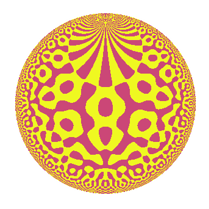

In [50]:
ppoints = 300
psize = 2.2
thiscmap = "plasma"

start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=ppoints, aspect_ratio=1, figsize=[psize, psize],
             dark_rate=0.0, contoured=True, cmap=thiscmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save(f"cmap_{thiscmap}.png", figsize=[psize, psize], axes=False, transparent=True)
P.show()

7.21473240852356 time elapsed


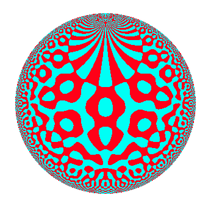

In [51]:
ppoints = 300
psize = 2.2
thiscmap = "hsv"

start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=ppoints, aspect_ratio=1, figsize=[psize, psize],
             dark_rate=0.0, contoured=True, cmap=thiscmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save(f"cmap_{thiscmap}.png", figsize=[psize, psize], axes=False, transparent=True)
P.show()

6.915740966796875 time elapsed


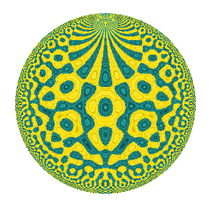

In [52]:
ppoints = 300
psize = 2.2
thiscmap = "viridis"

start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=ppoints, aspect_ratio=1, figsize=[psize, psize],
             contoured=True, cmap=thiscmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save(f"cmap_{thiscmap}_contoured.png", figsize=[psize, psize], axes=False, transparent=True)
P.show()

6.6668009757995605 time elapsed


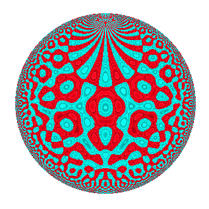

In [53]:
ppoints = 300
psize = 2.2
thiscmap = "hsv"

start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=ppoints, aspect_ratio=1, figsize=[psize, psize],
             contoured=True, cmap=thiscmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save(f"cmap_{thiscmap}_contoured.png", figsize=[psize, psize], axes=False, transparent=True)
P.show()

6.817875623703003 time elapsed


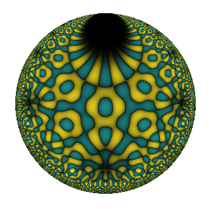

In [54]:
ppoints = 300
psize = 2.2
thiscmap = "viridis"

start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=ppoints, aspect_ratio=1, figsize=[psize, psize],
             cmap=thiscmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save(f"cmap_{thiscmap}_shadow.png", figsize=[psize, psize], axes=False, transparent=True)
P.show()

7.334819555282593 time elapsed


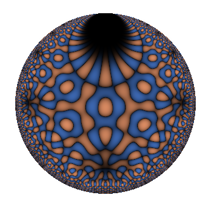

In [55]:
ppoints = 300
psize = 2.2
thiscmap = tcmap

start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=ppoints, aspect_ratio=1, figsize=[psize, psize],
             cmap=thiscmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save(f"cmap_quanta_shadow.png", figsize=[psize, psize], axes=False, transparent=True)
P.show()

8.387713193893433 time elapsed


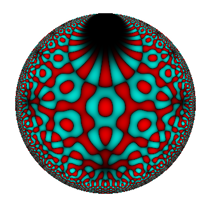

In [56]:
ppoints = 300
psize = 2.2
thiscmap = "matplotlib"

start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=ppoints, aspect_ratio=1, figsize=[psize, psize],
             cmap=thiscmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save(f"cmap_{thiscmap}_shadow.png", figsize=[psize, psize], axes=False, transparent=True)
P.show()

8.238224744796753 time elapsed


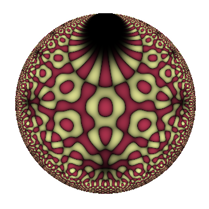

In [57]:
ppoints = 300
psize = 2.2
thiscmap = "inferno"

start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=ppoints, aspect_ratio=1, figsize=[psize, psize],
             cmap=thiscmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save(f"cmap_{thiscmap}_shadow.png", figsize=[psize, psize], axes=False, transparent=True)
P.show()

6.841263055801392 time elapsed


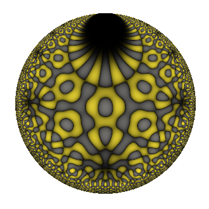

In [58]:
ppoints = 300
psize = 2.2
thiscmap = "cividis"

start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=ppoints, aspect_ratio=1, figsize=[psize, psize],
             cmap=thiscmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save(f"cmap_{thiscmap}_shadow.png", figsize=[psize, psize], axes=False, transparent=True)
P.show()

6.529633522033691 time elapsed


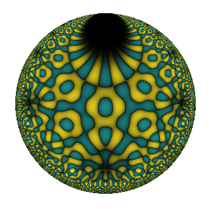

In [59]:
ppoints = 300
psize = 2.2
thiscmap = "viridis"

start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=ppoints, aspect_ratio=1, figsize=[psize, psize],
             cmap=thiscmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save(f"cmap_{thiscmap}_shadow.png", figsize=[psize, psize], axes=False, transparent=True)
P.show()

7.6105873584747314 time elapsed


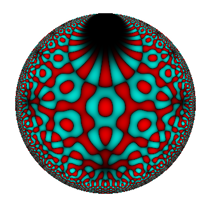

In [60]:
ppoints = 300
psize = 2.2
thiscmap = "matplotlib"

start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=ppoints, aspect_ratio=1, figsize=[psize, psize],
            cmap=thiscmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save(f"cmap_{thiscmap}_shadow.png", figsize=[psize, psize], axes=False, transparent=True)
P.show()

6.639324426651001 time elapsed


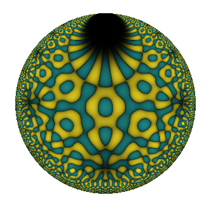

In [61]:
ppoints = 300
psize = 2.2
thiscmap = "viridis"

start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=ppoints, aspect_ratio=1, figsize=[psize, psize],
             dark_rate=0.4, cmap=thiscmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save(f"cmap_{thiscmap}_shadow.png", figsize=[psize, psize], axes=False, transparent=True)
P.show()

6.8032920360565186 time elapsed


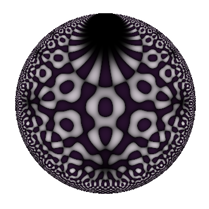

In [62]:
ppoints = 300
psize = 2.2
thiscmap = "twilight"

start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=ppoints, aspect_ratio=1, figsize=[psize, psize],
             cmap=thiscmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save(f"cmap_{thiscmap}_shadow.png", figsize=[psize, psize], axes=False, transparent=True)
P.show()

7.348495006561279 time elapsed


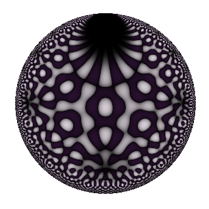

In [63]:
ppoints = 300
psize = 2.2
thiscmap = "twilight_shifted"

start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=ppoints, aspect_ratio=1, figsize=[psize, psize],
             cmap=thiscmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save(f"cmap_{thiscmap}_shadow.png", figsize=[psize, psize], axes=False, transparent=True)
P.show()

7.282789945602417 time elapsed


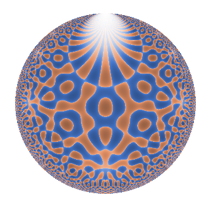

In [64]:
ppoints = 300
psize = 2.2
thiscmap = tcmap

start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else 1./fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=ppoints, aspect_ratio=1, figsize=[psize, psize],
             dark_rate=0.3, cmap=thiscmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save(f"cmap_quanta_light.png", figsize=[psize, psize], axes=False, transparent=True)
P.show()

7.210613012313843 time elapsed


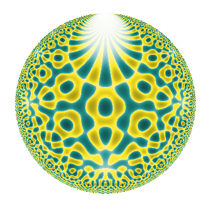

In [65]:
ppoints = 300
psize = 2.2
thiscmap = "viridis"

start = time.time()
P = complex_plot(lambda z: +Infinity if abs(z) >= 0.99 else 1./fcc(DtoH(z)),
             (-1, 1), (-1, 1), plot_points=ppoints, aspect_ratio=1, figsize=[psize, psize],
             dark_rate=0.6, cmap=thiscmap)
end = time.time()
print(f"{end - start} time elapsed")
P.axes(False)
P.save(f"cmap_{thiscmap}_light.png", figsize=[psize, psize], axes=False, transparent=True)
P.show()